In [1]:
#PARAMETERS
BATCH_SIZE = 12
NUM_EPOCHS = 10
LEARNING_RATE = 0.005
TRAIN_PERCENTAGE = .8

In [2]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torch.optim import SGD
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from engine import train_one_epoch, evaluate

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import json
import PIL.Image

In [3]:
%%cmd
git clone https://github.com/pytorch/vision.git

Microsoft Windows [Version 10.0.19045.3086]
(c) Microsoft Corporation. Alle Rechte vorbehalten.

(DV-STA) c:\GIT_Workspaces\Deep-Vision-sta\Faster R-CNN>git clone https://github.com/pytorch/vision.git


fatal: destination path 'vision' already exists and is not an empty directory.



(DV-STA) c:\GIT_Workspaces\Deep-Vision-sta\Faster R-CNN>

In [4]:
import shutil

#FUNCTIONS ARE MODIFIED DO NOT RUN THIS OR PROGRESS WILL BE LOST!
# shutil.copy("vision/references/detection/utils.py", "./")
# shutil.copy("vision/references/detection/transforms.py", "./")
# shutil.copy("vision/references/detection/coco_eval.py", "./")
# shutil.copy("vision/references/detection/engine.py", "./")
# shutil.copy("vision/references/detection/coco_utils.py", "./")

In [5]:
import cv2
from IPython.display import display, Image

def draw_annotation(image_path, annotation):
    # Load the image
    image = cv2.imread(image_path)
    
    # Extract the annotation details
    filename = annotation["FileName"]
    annotations = annotation["Annotations"]
    
    # Process each annotation
    for annot in annotations:
        bounding_box = annot["BoundingBox"]
        class_name = annot["classname"]
        
        # Draw the bounding box
        x_min, y_min, x_max, y_max = bounding_box
        print(x_min, y_min, x_max, y_max)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        
        # Add the class label
        text = f"{class_name}"
        cv2.putText(image, text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        #make a dot at x_min, y_min and x_max, y_max
        cv2.circle(image, (x_min, y_min), 5, (0, 0, 255), -1)
        cv2.circle(image, (x_max, y_max), 5, (255, 0, 0), -1)
    
    # Save the image with annotations
    annotated_image_path = "annotated_image.jpg"
    cv2.imwrite(annotated_image_path, image)
    
    # Display the image in the notebook
    display(Image(filename=annotated_image_path))


In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_sample(dataloader, x):
    # Rufen Sie das x-te Element aus dem Dataloader ab
    images, annotations = next(iter(dataloader))
    image = images[x]
    boxes = annotations[x]['annotations']

    # Erstellen Sie eine neue Figur und Achse
    fig, ax = plt.subplots(1)

    # Zeigen Sie das Bild in der Achse an
    ax.imshow(image.permute(1, 2, 0))

    # Iterieren Sie über die Bounding Boxes und zeichnen Sie sie als Rechtecke in der Achse
    for box in boxes:
        x_min, y_min, x_max, y_max = box['bbox']
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)


    # Zeigen Sie die visualisierten Bounding Boxes an
    plt.show()

In [7]:
CLASS_LABELS = {
    "hijab_niqab": 0,
    "mask_colorful": 1,
    "mask_surgical": 2,
    "face_no_mask": 3,
    "face_with_mask_incorrect": 4,
    "face_with_mask": 5,
    "face_other_covering": 6,
    "scarf_bandana": 7,
    "balaclava_ski_mask": 8,
    "face_shield": 9,
    "other": 10,
    "gas_mask": 11,
    "turban": 12,
    "helmet": 13,
    "sunglasses": 14,
    "eyeglasses": 15,
    "hair_net": 16,
    "hat": 17,
    "goggles": 18,
    "hood": 19
}

{'FileName': '2006.jpg', 'NumOfAnno': 4, 'Annotations': [{'isProtected': False, 'ID': 280459329561863488, 'BoundingBox': [276, 145, 377, 255], 'classname': 'face_with_mask', 'Confidence': 1, 'Attributes': {}}, {'isProtected': False, 'ID': 239543555427487392, 'BoundingBox': [207, 50, 310, 178], 'classname': 'face_with_mask', 'Confidence': 1, 'Attributes': {}}, {'isProtected': False, 'ID': 442800710251389568, 'BoundingBox': [287, 188, 364, 245], 'classname': 'mask_surgical', 'Confidence': 1, 'Attributes': {}}, {'isProtected': False, 'ID': 293325675214463168, 'BoundingBox': [219, 96, 303, 169], 'classname': 'mask_surgical', 'Confidence': 1, 'Attributes': {}}]}
276 145 377 255
207 50 310 178
287 188 364 245
219 96 303 169


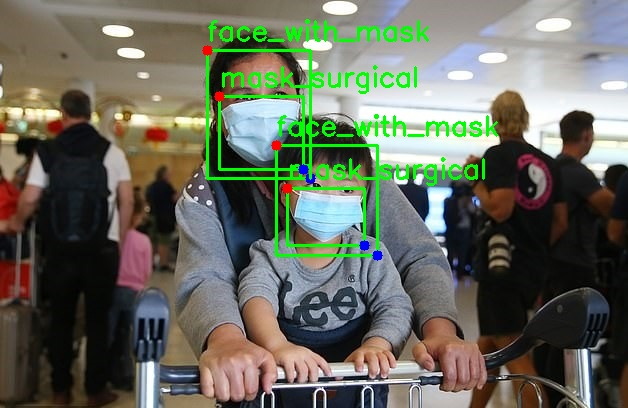

In [8]:
number = 2006


image_path = "C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask\images\\{number}.jpg".format(number=number)

#read json file
import json
with open('C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask\\annotations\\{number}.jpg.json'.format(number=number)) as json_file:
    annotation = json.load(json_file)

print(annotation)

draw_annotation(image_path, annotation)

In [9]:
#open the json file at Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\meta.json

import json
with open('C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\meta.json') as json_file:
    meta = json.load(json_file)

#copunt the entries in classes
print(len(meta["classes"]))

20


In [10]:
#iterate through all annotation files and search for invalid bounding boxes
import os
import json
#from PIL import Image

# Get the path to the annotations
annotations_path = "C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask\\annotations"

# Get the path to the images
images_path = "C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask\images"

# Get the list of all annotations
annotation_files = os.listdir(annotations_path)


# # Iterate through each annotation file
# for annotation_file in annotation_files:
#     # Build the path to the annotation file
#     annotation_file_path = os.path.join(annotations_path, annotation_file)
    
#     # Open the annotation file
#     with open(annotation_file_path) as file:
#         # Load the annotation file
#         annotation = json.load(file)
        
#         # Get the image filename
#         image_filename = annotation["FileName"]
        
#         # Build the path to the image file
#         image_file_path = os.path.join(images_path, image_filename)
        
#         # Open the image
#         image = Image.open(image_file_path)
        
#         # Get the image size
#         image_width, image_height = image.size
        
#         # Get the list of annotations
#         annotations = annotation["Annotations"]
        
#         # Iterate through each annotation
#         for annotation in annotations:
#             # Get the bounding box coordinates
#             x_min = annotation["BoundingBox"][0]
#             y_min = annotation["BoundingBox"][1]
#             x_max = annotation["BoundingBox"][2]
#             y_max = annotation["BoundingBox"][3]

#             print(x_min, x_max, y_min, y_max)
            
#             # Check if any coordinate exceeds the image boundaries
#             if x_min > image_width or y_min > image_height or x_max > image_width or y_max > image_height:
#                 print("Invalid bounding box coordinates in file:", image_file_path)
#                 break

#             if x_min > x_max or y_min > y_max:
#                 print("Invalid bounding box coordinates in file:", image_file_path)
                #break

In [11]:
import os
import PIL.Image as Image

import cv2
import numpy as np
import torch
import torchvision.transforms.functional as F
import os
import json
import PIL.Image
import xml.etree.ElementTree as et

class MaskDetectionDataset(Dataset):
    def __init__(self, root_dir, target_size=(600, 900)):
        self.root_dir = root_dir
        self.annotations = []
        self.target_size = target_size
        self.load_annotations()

    def load_annotations(self):
        annotation_files = os.listdir(f"{self.root_dir}/annotations")
        for file_name in annotation_files:
            with open(f"{self.root_dir}/annotations/{file_name}", "r") as f:
                annotation_data = json.load(f)
                annotations = annotation_data["Annotations"]
                file_name = annotation_data["FileName"]
                self.annotations.append((annotations, file_name))
                # Check if the boxes are valid
                for annotation in annotations:
                    boxes = annotation["BoundingBox"]
                    if boxes[0] >= boxes[2] or boxes[1] >= boxes[3]:
                        print("Invalid bounding box coordinates in file:", file_name)
                        break

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotations = self.annotations[idx][0]
        file_name = self.annotations[idx][1]
        image_path = f"{self.root_dir}/images/{file_name}"
        image = PIL.Image.open(image_path).convert("RGB")
        original_image_width, original_image_height = image.size
        image = F.resize(image, self.target_size)
        image = F.to_tensor(image)

        boxes = []
        labels = []
        for annotation in annotations:
            box = annotation["BoundingBox"]
            if box[0] < box[2] and box[1] < box[3]:
                # Resize the bounding box coordinates
                box_resized = [
                    box[0] * self.target_size[0] / original_image_width,
                    box[1] * self.target_size[1] / original_image_height,
                    box[2] * self.target_size[0] / original_image_width,
                    box[3] * self.target_size[1] / original_image_height
                ]
                boxes.append(box_resized)
                class_name = annotation["classname"]
                # Get the class label based on the class name
                class_label = self.get_class_label(class_name)
                labels.append(class_label)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        target["image_id"] = torch.tensor([idx])

        return image, target

    
    def get_class_label(self, class_name):
        return CLASS_LABELS.get(class_name, -1)  # Return -1 if class_name is not found






In [12]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [13]:
dataset = MaskDetectionDataset("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask",(512,512))

#dataset.annotations[1][0]

dataset.__getitem__(1)

(tensor([[[0.9765, 0.9804, 0.9804,  ..., 0.8196, 0.8471, 0.8706],
          [0.9843, 0.9843, 0.9882,  ..., 0.8510, 0.8784, 0.9020],
          [0.9922, 0.9922, 0.9961,  ..., 0.8980, 0.9255, 0.9451],
          ...,
          [0.7333, 0.7333, 0.7176,  ..., 0.2980, 0.2706, 0.2588],
          [0.7294, 0.7333, 0.7216,  ..., 0.2784, 0.2588, 0.2471],
          [0.7255, 0.7333, 0.7294,  ..., 0.2667, 0.2510, 0.2431]],
 
         [[0.9922, 1.0000, 1.0000,  ..., 0.6588, 0.6902, 0.7137],
          [0.9922, 1.0000, 1.0000,  ..., 0.6941, 0.7216, 0.7451],
          [0.9922, 1.0000, 1.0000,  ..., 0.7412, 0.7725, 0.7922],
          ...,
          [0.6941, 0.6980, 0.6902,  ..., 0.1882, 0.1647, 0.1490],
          [0.6902, 0.6980, 0.6980,  ..., 0.1686, 0.1529, 0.1373],
          [0.6863, 0.7020, 0.7020,  ..., 0.1569, 0.1412, 0.1333]],
 
         [[1.0000, 1.0000, 0.9882,  ..., 0.4157, 0.4471, 0.4706],
          [1.0000, 0.9961, 0.9765,  ..., 0.4471, 0.4784, 0.5020],
          [0.9882, 0.9765, 0.9569,  ...,

In [14]:


# Split the dataset into training and validation sets (adjust the split ratio as needed)
train_size = int(TRAIN_PERCENTAGE * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


In [15]:
dataset[1]

(tensor([[[0.9765, 0.9804, 0.9804,  ..., 0.8196, 0.8471, 0.8706],
          [0.9843, 0.9843, 0.9882,  ..., 0.8510, 0.8784, 0.9020],
          [0.9922, 0.9922, 0.9961,  ..., 0.8980, 0.9255, 0.9451],
          ...,
          [0.7333, 0.7333, 0.7176,  ..., 0.2980, 0.2706, 0.2588],
          [0.7294, 0.7333, 0.7216,  ..., 0.2784, 0.2588, 0.2471],
          [0.7255, 0.7333, 0.7294,  ..., 0.2667, 0.2510, 0.2431]],
 
         [[0.9922, 1.0000, 1.0000,  ..., 0.6588, 0.6902, 0.7137],
          [0.9922, 1.0000, 1.0000,  ..., 0.6941, 0.7216, 0.7451],
          [0.9922, 1.0000, 1.0000,  ..., 0.7412, 0.7725, 0.7922],
          ...,
          [0.6941, 0.6980, 0.6902,  ..., 0.1882, 0.1647, 0.1490],
          [0.6902, 0.6980, 0.6980,  ..., 0.1686, 0.1529, 0.1373],
          [0.6863, 0.7020, 0.7020,  ..., 0.1569, 0.1412, 0.1333]],
 
         [[1.0000, 1.0000, 0.9882,  ..., 0.4157, 0.4471, 0.4706],
          [1.0000, 0.9961, 0.9765,  ..., 0.4471, 0.4784, 0.5020],
          [0.9882, 0.9765, 0.9569,  ...,

In [16]:
len(dataset)

4326

In [17]:
def collate_fn2(batch):
    images = [item["image"] for item in batch]
    targets = [item["targets"] for item in batch if item["targets"]]

    if targets:
        targets = [{k: v for k, v in target.items()} for target in targets]  # Remove the "to(device)" part
        return {
            "image": torch.stack(images),
            "targets": targets
        }
    else:
        return {
            "image": torch.stack(images),
            "targets": []  # Return an empty list if targets is empty
        }

In [18]:
import utils

train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=utils.collate_fn)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=utils.collate_fn)

In [19]:
#get the first batch
out = next(iter(train_data_loader))

out

((tensor([[[0.6588, 0.6588, 0.6588,  ..., 0.5137, 0.5137, 0.5137],
           [0.6588, 0.6588, 0.6588,  ..., 0.5176, 0.5176, 0.5176],
           [0.6627, 0.6627, 0.6627,  ..., 0.5176, 0.5176, 0.5176],
           ...,
           [0.3294, 0.3216, 0.3216,  ..., 0.1647, 0.1529, 0.1804],
           [0.3294, 0.3216, 0.3216,  ..., 0.1255, 0.1216, 0.1647],
           [0.3333, 0.3255, 0.3216,  ..., 0.1137, 0.1137, 0.1647]],
  
          [[0.5922, 0.5922, 0.5922,  ..., 0.4706, 0.4706, 0.4706],
           [0.5922, 0.5922, 0.5922,  ..., 0.4745, 0.4745, 0.4745],
           [0.5961, 0.5961, 0.5961,  ..., 0.4745, 0.4745, 0.4745],
           ...,
           [0.3294, 0.3216, 0.3216,  ..., 0.1686, 0.1569, 0.1843],
           [0.3255, 0.3216, 0.3216,  ..., 0.1255, 0.1255, 0.1686],
           [0.3294, 0.3216, 0.3216,  ..., 0.1137, 0.1176, 0.1686]],
  
          [[0.4941, 0.4941, 0.4941,  ..., 0.3961, 0.3961, 0.3961],
           [0.4941, 0.4941, 0.4941,  ..., 0.4000, 0.4000, 0.4000],
           [0.4980, 0.

In [20]:
dataset.__len__()

4326

In [21]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 20
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

c:\Users\johan\.conda\envs\DV-STA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\johan\.conda\envs\DV-STA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler (optional)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [23]:
#deleteme
import torchvision.models.detection as detection

#criterion = detection.fasterrcnn_loss



In [24]:
import time
import torchvision.models.detection as detection


def train(model, data_loader, optimizer, device):
    model.train()
    total_iterations = len(data_loader)
    start_time = time.time()
    for iteration, batch in enumerate(data_loader, 1):
        images = batch["image"]
        targets = batch["targets"]
        #print(targets)

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        elapsed_time = time.time() - start_time
        avg_time_per_iteration = elapsed_time / iteration
        remaining_iterations = total_iterations - iteration
        eta = avg_time_per_iteration * remaining_iterations

        print(f"Iteration: {iteration}/{total_iterations}, Remaining: {remaining_iterations}, ETA: {eta:.2f} seconds, Loss: {losses:.4f}", end="\r")




#EVAL RETurNT ANDERE WERTE GOOGELN
#auch checken im dataset welche klassen zgeordnet werden und wieviele klassen angegeben werden
def validate(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    #criterion = torch.nn.CrossEntropyLoss()  # Use appropriate loss function
    # Get the criterion (loss function)
    criterion = detection.fasterrcnn_loss

    with torch.no_grad():
        for batch in data_loader:
            images = batch["image"]
            targets = batch["targets"]

            images = [img.to(device) for img in images]
            labels = [target['labels'].to(device) for target in targets]

            outputs = model(images)
            predicted_labels = [output['labels'] for output in outputs]
            predicted_labels = torch.cat(predicted_labels)

            # Flatten the ground truth labels and convert them to 'Long' type
            flattened_labels = torch.cat(labels)
            flattened_labels = flattened_labels.long()

            loss = criterion(outputs['labels'], flattened_labels)
            total_loss += loss.item()

    average_loss = total_loss / len(data_loader)
    return average_loss




In [25]:
# from typing import Tuple, List, Dict, Optional
# import torch
# from torch import Tensor
# from collections import OrderedDict
# from torchvision.models.detection.roi_heads import fastrcnn_loss
# from torchvision.models.detection.rpn import concat_box_prediction_layers
# def eval_forward(model, images, targets):
#     """
#     Args:
#         images (list[Tensor]): images to be processed
#         targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
#     Returns:
#         result (list[BoxList] or dict[Tensor]): the output from the model.
#             It returns list[BoxList] contains additional fields
#             like `scores`, `labels` and `mask` (for Mask R-CNN models).
#     """
#     model.eval()

#     original_image_sizes: List[Tuple[int, int]] = []
#     for img in images:
#         val = img.shape[-2:]
#         assert len(val) == 2
#         original_image_sizes.append((val[0], val[1]))

#     images, targets = model.transform(images, targets)

#     # Check for degenerate boxes
#     # TODO: Move this to a function
#     if targets is not None:
#         for target_idx, target in enumerate(targets):
#             boxes = target["boxes"]
#             degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
#             if degenerate_boxes.any():
#                 # print the first degenerate box
#                 bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
#                 degen_bb: List[float] = boxes[bb_idx].tolist()
#                 raise ValueError(
#                     "All bounding boxes should have positive height and width."
#                     f" Found invalid box {degen_bb} for target at index {target_idx}."
#                 )

#     features = model.backbone(images.tensors)
#     if isinstance(features, torch.Tensor):
#         features = OrderedDict([("0", features)])
#     model.rpn.training=True
#     #model.roi_heads.training=True


#     #####proposals, proposal_losses = model.rpn(images, features, targets)
#     features_rpn = list(features.values())
#     objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
#     anchors = model.rpn.anchor_generator(images, features_rpn)

#     num_images = len(anchors)
#     num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
#     num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
#     objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
#     # apply pred_bbox_deltas to anchors to obtain the decoded proposals
#     # note that we detach the deltas because Faster R-CNN do not backprop through
#     # the proposals
#     proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
#     proposals = proposals.view(num_images, -1, 4)
#     proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

#     proposal_losses = {}
#     assert targets is not None
#     labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
#     regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
#     loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
#         objectness, pred_bbox_deltas, labels, regression_targets
#     )
#     proposal_losses = {
#         "loss_objectness": loss_objectness,
#         "loss_rpn_box_reg": loss_rpn_box_reg,
#     }

#     #####detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
#     image_shapes = images.image_sizes
#     proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)
#     box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
#     box_features = model.roi_heads.box_head(box_features)
#     class_logits, box_regression = model.roi_heads.box_predictor(box_features)

#     result: List[Dict[str, torch.Tensor]] = []
#     detector_losses = {}
#     loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
#     detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
#     boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
#     num_images = len(boxes)
#     for i in range(num_images):
#         result.append(
#             {
#                 "boxes": boxes[i],
#                 "labels": labels[i],
#                 "scores": scores[i],
#             }
#         )
#     detections = result
#     detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]
#     model.rpn.training=False
#     model.roi_heads.training=False
#     losses = {}
#     losses.update(detector_losses)
#     losses.update(proposal_losses)
#     return losses, detections

In [26]:
# import torch
# from torch.utils.data import DataLoader
# from torchvision.models.detection.roi_heads import fastrcnn_loss

# def calculate_validation_loss(model, data_loader, criterion, device):
#     model.eval()
#     total_loss = 0.0
#     num_samples = 0

#     with torch.no_grad():
#         for batch in data_loader:
#             images = batch['image'].to(device)
#             targets = batch['targets']

#             # Unpack targets dictionary
#             boxes = [target['boxes'].to(device) for target in targets]
#             labels = [target['labels'].to(device) for target in targets]

#             outputs = model(images)

#             # Process model outputs
#             class_logits = [output['scores'] for output in outputs]
#             box_regression = [output['boxes'] for output in outputs]

#             # Calculate the fasterrcnn_loss
#             loss, _ = criterion(torch.cat(class_logits), torch.cat(box_regression), labels, boxes)

#             total_loss += loss.item() * images.size(0)
#             num_samples += images.size(0)

#     validation_loss = total_loss / num_samples
#     return validation_loss


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

device

device(type='cuda')

In [28]:
# num_epochs = 1  # Adjust the number of epochs as needed

# for epoch in range(NUM_EPOCHS):
#     train(model, train_data_loader, optimizer, device)
#     #val_loss = validate(model, val_data_loader, device)
#     #val_loss = calculate_validation_loss(model, val_data_loader, fastrcnn_loss, device)
#     #print(f"Epoch: {epoch+1}, Validation Loss: {val_loss}")


In [29]:
evaluator = 0

In [30]:
from engine import train_one_epoch, evaluate

# Define empty arrays to collect metrics
ap_values = []
ar_values = []

losses = []

for epoch in range(NUM_EPOCHS):
    # training for one epoch
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=1, losses_out=losses)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # adjusted numpy library code for evaluate to work with newer numpy versions
    evaluator = evaluate(model, val_data_loader, device=device)
    #print(evaluator)

    # Extract the metrics from the evaluator
    iou_thresholds = evaluator.coco_eval['bbox'].params.iouThrs
    average_precisions = evaluator.coco_eval['bbox'].stats[:6]
    average_recalls = evaluator.coco_eval['bbox'].stats[6:]

    # Append the metrics to the arrays
    ap_values.append(average_precisions)
    ar_values.append(average_recalls)


Epoch: [0]  [  0/267]  eta: 0:15:11  lr: 0.000024  loss: 3.6446 (3.6446)  loss_classifier: 3.3201 (3.3201)  loss_box_reg: 0.2137 (0.2137)  loss_objectness: 0.0960 (0.0960)  loss_rpn_box_reg: 0.0148 (0.0148)  time: 3.4140  data: 0.1645  max mem: 9253
Epoch: [0]  [  1/267]  eta: 0:09:29  lr: 0.000043  loss: 3.6446 (3.6811)  loss_classifier: 3.3201 (3.3368)  loss_box_reg: 0.2137 (0.2356)  loss_objectness: 0.0917 (0.0939)  loss_rpn_box_reg: 0.0147 (0.0147)  time: 2.1400  data: 0.1548  max mem: 9410
Epoch: [0]  [  2/267]  eta: 0:07:32  lr: 0.000061  loss: 3.7059 (3.6893)  loss_classifier: 3.3201 (3.3266)  loss_box_reg: 0.2383 (0.2365)  loss_objectness: 0.0960 (0.1074)  loss_rpn_box_reg: 0.0148 (0.0187)  time: 1.7080  data: 0.1528  max mem: 9410
Epoch: [0]  [  3/267]  eta: 0:06:41  lr: 0.000080  loss: 3.6446 (3.6757)  loss_classifier: 3.3063 (3.3098)  loss_box_reg: 0.2383 (0.2490)  loss_objectness: 0.0917 (0.0989)  loss_rpn_box_reg: 0.0148 (0.0181)  time: 1.5195  data: 0.1784  max mem: 9410


RuntimeError: CUDA error: misaligned address
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


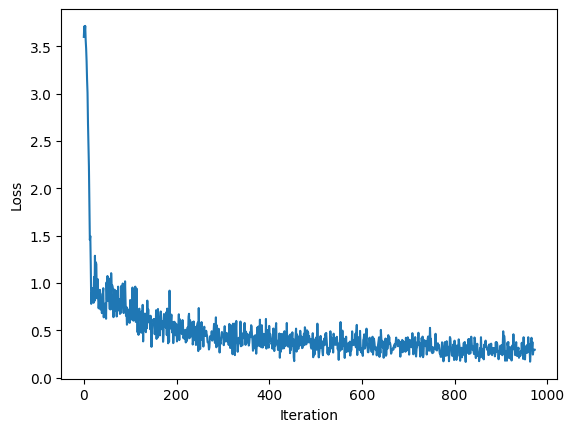

In [ ]:
%matplotlib inline

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

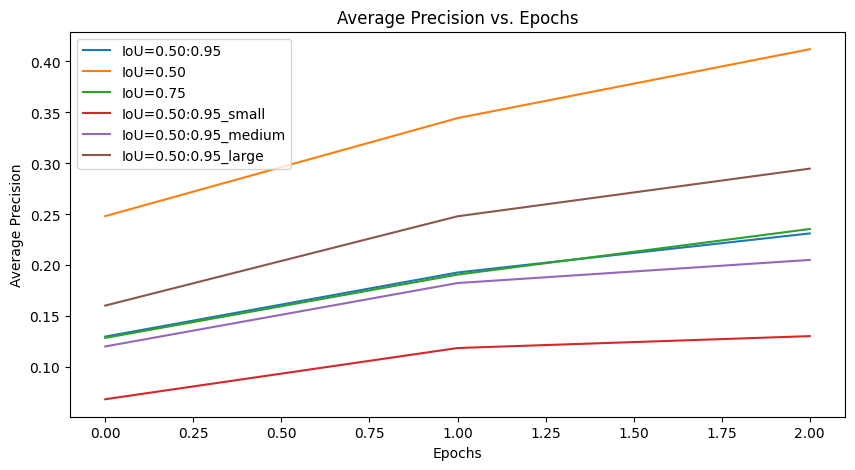

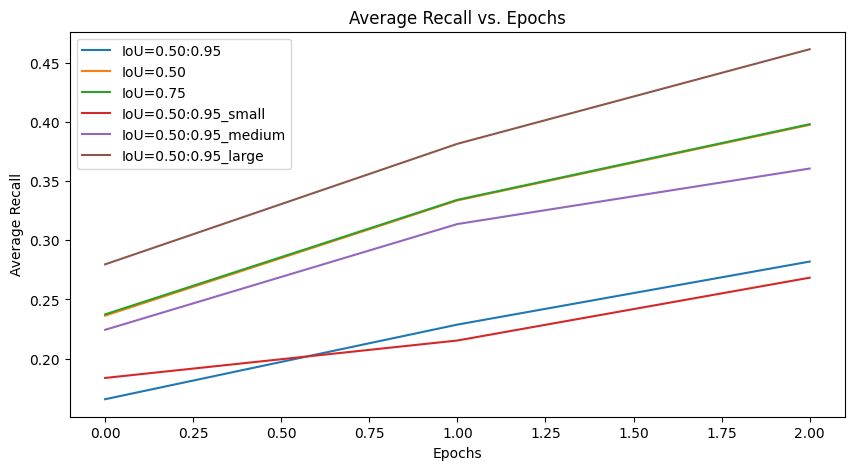

In [ ]:
%matplotlib inline

# Convert the arrays to numpy arrays for easier plotting
ap_values = np.array(ap_values)
ar_values = np.array(ar_values)

iou_thresholds_available = ["0.50:0.95", "0.50", "0.75", "0.50:0.95_small", "0.50:0.95_medium", "0.50:0.95_large"]

# Plot the average precisions over epochs
plt.figure(figsize=(10, 5))
for i, iou_thresh in enumerate(iou_thresholds_available):
    plt.plot(ap_values[:, i], label=f"IoU={iou_thresh}")
plt.xlabel("Epochs")
plt.ylabel("Average Precision")
plt.title("Average Precision vs. Epochs")
plt.legend()
plt.show()

# Plot the average recalls over epochs
plt.figure(figsize=(10, 5))
for i, iou_thresh in enumerate(iou_thresholds_available):
    plt.plot(ar_values[:, i], label=f"IoU={iou_thresh}")
plt.xlabel("Epochs")
plt.ylabel("Average Recall")
plt.title("Average Recall vs. Epochs")
plt.legend()
plt.show()

In [ ]:
iter = iter(val_data_loader)

In [ ]:


samples = next(iter)

#get a sample from the samples

sample = samples[0]
image = sample[0]

# model.eval()
# with torch.no_grad():
#     predictions = model(samples[0].to(device))

# prediction
samples

((tensor([[[0.1882, 0.1882, 0.1882,  ..., 0.3686, 0.3843, 0.3961],
           [0.1882, 0.1882, 0.1882,  ..., 0.3725, 0.3882, 0.4039],
           [0.1882, 0.1882, 0.1882,  ..., 0.3725, 0.3922, 0.4078],
           ...,
           [0.5020, 0.5176, 0.5255,  ..., 0.3137, 0.3098, 0.3098],
           [0.4980, 0.5137, 0.5333,  ..., 0.3137, 0.3098, 0.3098],
           [0.4980, 0.5294, 0.5608,  ..., 0.3137, 0.3098, 0.3098]],
  
          [[0.1922, 0.1922, 0.1922,  ..., 0.3098, 0.3137, 0.3255],
           [0.1922, 0.1922, 0.1922,  ..., 0.3137, 0.3216, 0.3294],
           [0.1922, 0.1922, 0.1922,  ..., 0.3176, 0.3216, 0.3333],
           ...,
           [0.4549, 0.4745, 0.4941,  ..., 0.2980, 0.2941, 0.2941],
           [0.4588, 0.4863, 0.5098,  ..., 0.2980, 0.2941, 0.2941],
           [0.4784, 0.5137, 0.5529,  ..., 0.2980, 0.2941, 0.2941]],
  
          [[0.1882, 0.1882, 0.1882,  ..., 0.3020, 0.2863, 0.2824],
           [0.1882, 0.1882, 0.1882,  ..., 0.3020, 0.2902, 0.2863],
           [0.1882, 0.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import Image, display

def visualize_prediction2(image, boxes, labels):
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image.permute(1, 2, 0))

    # Iterate over all bounding boxes
    for box, label in zip(boxes, labels):
        # Get the coordinates of the bounding box
        x_min, y_min, x_max, y_max = box

        # Create a Rectangle patch
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add the class label
        text = f"{label}"
        ax.text(x_min, y_min, text, bbox=dict(facecolor='white', alpha=0.5))

    # Save the plot as an image
    fig.savefig('output.png')

    # Close the figure to free up resources
    plt.close(fig)

    # Display the saved image
    display(Image('output.png'))

# Call the function with your image, bounding boxes, and labels
# visualize_prediction(image, boxes, labels)


In [ ]:
def visualize_prediction(images, model, confidence_threshold, allowed_labels = [3, 4, 5, 6]):
    # Set the model to evaluation mode
    model.eval()
    mean=[0.485, 0.456, 0.406] 
    std=[0.229, 0.224, 0.225]
    # Preprocess the images
    ims = list(image.to(device) for image in images)
    # Perform inference
    with torch.no_grad():
        predictions = model(ims)
        #good = torch.argwhere(scores > confidence_threshold)
        print(predictions)

    for image, prediction in zip(images, predictions):
        # Convert the image tensor to a PIL Image
        #image_pil = transforms.ToPILImage()(image)

        # Unnormalize the image
        image_pil = transforms.ToPILImage()(image)


        # Get the predicted bounding boxes, labels, and scores
        boxes = prediction['boxes'].cpu().numpy()
        labels = prediction['labels'].cpu().numpy()
        scores = prediction['scores'].cpu().numpy()

        # Visualize the image and predicted bounding boxes
        fig, ax = plt.subplots(1)
        ax.imshow(image_pil)

        for box, label, score in zip(boxes, labels, scores):
            if label in allowed_labels and score > confidence_threshold:
                x_min, y_min, x_max, y_max = box
                width = x_max - x_min
                height = y_max - y_min
                class_name = list(CLASS_LABELS.keys())[list(CLASS_LABELS.values()).index(label)]
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min, f"{class_name}", color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

        plt.show()
    model.train()

In [ ]:
samples[0][0]

tensor([[[0.1882, 0.1882, 0.1882,  ..., 0.3686, 0.3843, 0.3961],
         [0.1882, 0.1882, 0.1882,  ..., 0.3725, 0.3882, 0.4039],
         [0.1882, 0.1882, 0.1882,  ..., 0.3725, 0.3922, 0.4078],
         ...,
         [0.5020, 0.5176, 0.5255,  ..., 0.3137, 0.3098, 0.3098],
         [0.4980, 0.5137, 0.5333,  ..., 0.3137, 0.3098, 0.3098],
         [0.4980, 0.5294, 0.5608,  ..., 0.3137, 0.3098, 0.3098]],

        [[0.1922, 0.1922, 0.1922,  ..., 0.3098, 0.3137, 0.3255],
         [0.1922, 0.1922, 0.1922,  ..., 0.3137, 0.3216, 0.3294],
         [0.1922, 0.1922, 0.1922,  ..., 0.3176, 0.3216, 0.3333],
         ...,
         [0.4549, 0.4745, 0.4941,  ..., 0.2980, 0.2941, 0.2941],
         [0.4588, 0.4863, 0.5098,  ..., 0.2980, 0.2941, 0.2941],
         [0.4784, 0.5137, 0.5529,  ..., 0.2980, 0.2941, 0.2941]],

        [[0.1882, 0.1882, 0.1882,  ..., 0.3020, 0.2863, 0.2824],
         [0.1882, 0.1882, 0.1882,  ..., 0.3020, 0.2902, 0.2863],
         [0.1882, 0.1882, 0.1882,  ..., 0.3020, 0.2941, 0.

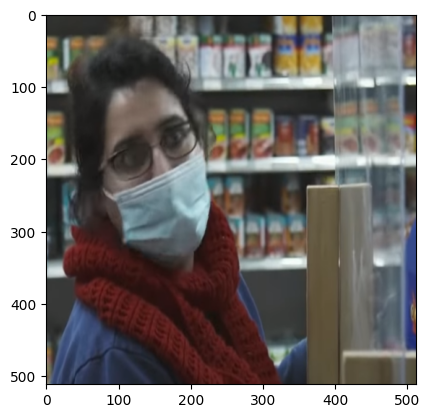

In [ ]:
%matplotlib inline

image_pil = transforms.ToPILImage()(samples[0][0])

fig, ax = plt.subplots(1)
ax.imshow(image_pil)
plt.show()


In [ ]:
visualize_prediction(samples[0], model, 0.5, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

RuntimeError: CUDA error: misaligned address
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
model.eval()
model([image.to(device)])

[{'boxes': tensor([[138.4595, 138.0670, 240.9992, 232.5354],
          [119.2536,  31.5264, 251.2156, 234.8511],
          [117.4403,  29.7818, 242.6741, 130.8194],
          [471.7061, 127.5049, 499.7141, 171.9126],
          [115.9103,  28.3696, 249.4509, 236.0159],
          [128.6703, 107.1611, 235.3981, 155.9420],
          [474.4750, 148.3896, 497.7244, 171.5526],
          [129.1784, 142.4487, 240.8732, 233.4933],
          [470.4988, 127.8369, 499.2496, 169.4061],
          [129.6908, 130.6096, 241.5482, 158.5671],
          [476.0805, 148.6403, 497.7970, 170.3908],
          [111.9149,  27.1345, 244.4486, 173.7648],
          [472.0246, 128.2131, 500.9645, 167.9593],
          [118.3695,  98.5616, 232.5684, 190.6344],
          [113.0830,  29.3001, 259.7026, 183.2230],
          [117.3777,  75.4161, 248.5066, 139.3132],
          [ 51.0652,  49.6792, 387.6855, 512.0000],
          [126.3910,  48.9575, 240.3771, 173.0003]], device='cuda:0',
         grad_fn=<StackBackward0>),
 

In [ ]:
dataset.__getitem__(1)

(tensor([[[0.9765, 0.9804, 0.9804,  ..., 0.8196, 0.8471, 0.8706],
          [0.9843, 0.9843, 0.9882,  ..., 0.8510, 0.8784, 0.9020],
          [0.9922, 0.9922, 0.9961,  ..., 0.8980, 0.9255, 0.9451],
          ...,
          [0.7333, 0.7333, 0.7176,  ..., 0.2980, 0.2706, 0.2588],
          [0.7294, 0.7333, 0.7216,  ..., 0.2784, 0.2588, 0.2471],
          [0.7255, 0.7333, 0.7294,  ..., 0.2667, 0.2510, 0.2431]],
 
         [[0.9922, 1.0000, 1.0000,  ..., 0.6588, 0.6902, 0.7137],
          [0.9922, 1.0000, 1.0000,  ..., 0.6941, 0.7216, 0.7451],
          [0.9922, 1.0000, 1.0000,  ..., 0.7412, 0.7725, 0.7922],
          ...,
          [0.6941, 0.6980, 0.6902,  ..., 0.1882, 0.1647, 0.1490],
          [0.6902, 0.6980, 0.6980,  ..., 0.1686, 0.1529, 0.1373],
          [0.6863, 0.7020, 0.7020,  ..., 0.1569, 0.1412, 0.1333]],
 
         [[1.0000, 1.0000, 0.9882,  ..., 0.4157, 0.4471, 0.4706],
          [1.0000, 0.9961, 0.9765,  ..., 0.4471, 0.4784, 0.5020],
          [0.9882, 0.9765, 0.9569,  ...,

In [ ]:
torch.save(model.state_dict(), "mask_detection_model.pth")
